In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
import random
import matplotlib
from matplotlib import pyplot as plt
import statistics
from pandas import DataFrame
from datetime import datetime
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
#from keras import backend as K
#import keras.backend.tensorflow_backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from os.path import basename
#import seaborn as sns
# from keras.models import load_model
# from keras.utils.vis_utils import plot_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.stats import pearsonr

# from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
#from tensorflow.keras.optimizers import Adam




# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.7
# config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


# 출처: https://3months.tistory.com/206 [Deep Play]

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3239628771207651120
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22904492544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17179497719961410036
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 22904492544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12081785751342387056
physical_device_desc: "device: 1, name: TITAN RTX, pci bus id: 0000:03:00.0, compute capability: 7.5"
]


In [3]:
workdir = "D://ResNetIC50//Dataset//MEYDC-6K"

In [4]:
# < Important note > [ Please download input data from https://mega.nz/#F!CeYGDKyS!uqkmWJ4E2XSGJp_C2VO2gg]

dataset = np.load(workdir + "//MEYDC6K_dataset.npz") # input file
ss0 = np.load(workdir + '//MEYDC6K_dataset_r0.npz') # split for training and test

In [5]:
x = dataset['x']
y = dataset['y']
# y_linear = dataset['y_lnIC50']
ss0_train = ss0['train']
ss0_test = ss0['test']

In [6]:
training_image_array, training_label_array = x[ss0_train], y[ss0_train]
test_image_array, test_label_array = x[ss0_test], y[ss0_test]

# # In[9]:
# ori = training_image_array
# bat = np.zeros((ori.shape[0],178))
# cat = np.hstack([ori,bat])
# training_image_array = cat

# # In[8]:
# training_image_array.shape

# # In[10]:
# ori2 = test_image_array
# bat2 = np.zeros((ori2.shape[0],178))
# cat2 = np.hstack([ori2,bat2])
# test_image_array = cat2


In [7]:
# In[15]:
ab =[]
for i in range(100,300):
    ab.append(len(training_image_array) % i)
    
print(min(ab), ab.index(min(ab)))

6 27


In [8]:
x.shape

(6074, 62718)

In [9]:
training_image_array.shape

(5467, 62718)

In [10]:
# In[21]:

num_classes = 1
learning_rate = 0.0002
training_epochs = 150
batch_size = 100
# img_rows, img_cols = 154, 154


In [11]:
train_X, train_y, test_X, test_y = training_image_array, training_label_array, test_image_array, test_label_array

# if K.image_data_format() == 'channels_first':
#     train_X = train_X.reshape(train_X.shape[0], 1, img_rows, img_cols)
#     test_X = test_X.reshape(x_test.shape[0], 1, img_rows, img_cols)
#     input_shape = (1, img_rows, img_cols)
# else:
#     train_X = train_X.reshape(train_X.shape[0], img_rows, img_cols, 1)
#     test_X = test_X.reshape(test_X.shape[0], img_rows, img_cols, 1)
#     input_shape = (img_rows, img_cols, 1)


In [12]:
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1],1)
#input_shape = (img_rows, img_cols, 1)

In [13]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5467, 62718, 1) (5467,) (607, 62718, 1) (607,)


In [14]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
# train_X /= 255
# test_X /= 255
print('train_X shape:', train_X.shape)
print(train_X.shape[0], 'train samples')
print(test_X.shape[0], 'test samples')

train_X shape: (5467, 62718, 1)
5467 train samples
607 test samples


In [15]:
training_image_array.shape

(5467, 62718)

In [16]:
# In[10]:
with tf.device('/GPU:0'):
    inputs = Input(shape=(train_X.shape[1],1),name='inputs')

    x = Conv1D(16, kernel_size=3, strides=2, padding="same")(inputs)
    x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
#     y = x
    x = Activation('tanh')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)

    
    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)
    
    
    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    
    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)
    
    x = Conv1D(32, kernel_size=3, strides=2, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
#     x = BatchNormalization()(x)
        
    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)
    
        
    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=2, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
#     x = BatchNormalization()(x)
        
    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)
    
        
    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)

#     x = AveragePooling1D(pool_size=8)(x)
    x = Flatten()(x)
    x = Dense(units=2048, name='dense1'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout1') (x)
    x = Activation('relu')(x)

#    x = Reshape((300,1))(x)

#    x = Conv1D(30, kernel_size=150, strides=1, activation = 'relu')(x)
#    x = MaxPooling1D(pool_size=2)(x)
#    x = BatchNormalization()(x)

    x = Dense(units=1024, name='dense5'  ) (x)
    x = BatchNormalization()(x)
    y = x
    x = Dropout(0.1, name='dropout5') (x)
    x = Activation('relu')(x)

    x = Dense(units=512, name='dense6'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout6') (x)
    x = Activation('relu')(x)

    x = Dense(units=1024, name='dense7'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout7') (x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)
    
    x = Dense(units=512, name='dense8'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout8') (x)
    x = Activation('relu')(x)
    
    x = Dense(units=256, name='dense9'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout9') (x)
    x = Activation('relu')(x)

    x = Dense(units=128, name='dense10'  ) (x)
    x = BatchNormalization()(x)
    y = x
    x = Dropout(0.1, name='dropout10') (x)
    x = Activation('relu')(x)


    predictions = Dense(1, activation='linear', name='predictions', kernel_initializer='he_normal')(x)
#     predictions = Dense(1, activation='linear', name='predictions')(x)

    

    model = Model(inputs=inputs, outputs=predictions, name='Test_v2_DNN20190327')
    model.compile(loss=tf.keras.losses.mean_squared_error,
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['mse','mae'])


    model.summary()


Model: "Test_v2_DNN20190327"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 62718, 1)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 31359, 16)    64          inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 6271, 16)     0           conv1d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 6271, 16)     64          max_pooling1d[0][0]              
________________________________________________________________________________

In [17]:
StartTime8 = datetime.now()
print("StartTime :", StartTime8)
with tf.device('/GPU:0'):
    model_train = model.fit(train_X, training_label_array, batch_size=batch_size,epochs=training_epochs,verbose=1,
                        validation_data=(test_X, test_label_array))

EndTime8 = datetime.now()
print("EndTime :", EndTime8)

StartTime : 2022-02-04 03:57:13.981253
Epoch 1/150
55/55 [==============================] - 17s 213ms/step - loss: 5.7067 - mse: 5.7067 - mae: 2.0618 - val_loss: 5.9258 - val_mse: 5.9258 - val_mae: 2.2893
Epoch 2/150
55/55 [==============================] - 11s 199ms/step - loss: 2.1277 - mse: 2.1277 - mae: 1.1064 - val_loss: 6.3415 - val_mse: 6.3415 - val_mae: 2.3714
Epoch 3/150
55/55 [==============================] - 11s 199ms/step - loss: 1.4577 - mse: 1.4577 - mae: 0.8729 - val_loss: 4.7493 - val_mse: 4.7493 - val_mae: 2.0272
Epoch 4/150
55/55 [==============================] - 11s 199ms/step - loss: 1.2411 - mse: 1.2411 - mae: 0.7993 - val_loss: 3.3627 - val_mse: 3.3627 - val_mae: 1.6462
Epoch 5/150
55/55 [==============================] - 11s 200ms/step - loss: 1.0723 - mse: 1.0723 - mae: 0.7302 - val_loss: 1.8467 - val_mse: 1.8467 - val_mae: 1.1347
Epoch 6/150
55/55 [==============================] - 11s 200ms/step - loss: 0.9397 - mse: 0.9397 - mae: 0.6853 - val_loss: 1.1787 -

Epoch 50/150
55/55 [==============================] - 11s 201ms/step - loss: 0.1689 - mse: 0.1689 - mae: 0.3014 - val_loss: 0.7616 - val_mse: 0.7616 - val_mae: 0.4482
Epoch 51/150
55/55 [==============================] - 11s 201ms/step - loss: 0.1752 - mse: 0.1752 - mae: 0.3067 - val_loss: 0.7617 - val_mse: 0.7617 - val_mae: 0.4490
Epoch 52/150
55/55 [==============================] - 11s 201ms/step - loss: 0.1677 - mse: 0.1677 - mae: 0.3047 - val_loss: 0.8304 - val_mse: 0.8304 - val_mae: 0.4690
Epoch 53/150
55/55 [==============================] - 11s 201ms/step - loss: 0.1645 - mse: 0.1645 - mae: 0.3019 - val_loss: 0.7821 - val_mse: 0.7821 - val_mae: 0.4626
Epoch 54/150
55/55 [==============================] - 11s 201ms/step - loss: 0.1571 - mse: 0.1571 - mae: 0.2906 - val_loss: 0.8110 - val_mse: 0.8110 - val_mae: 0.4828
Epoch 55/150
55/55 [==============================] - 11s 201ms/step - loss: 0.1693 - mse: 0.1693 - mae: 0.2995 - val_loss: 0.7767 - val_mse: 0.7767 - val_mae: 0.461

55/55 [==============================] - 11s 203ms/step - loss: 0.0877 - mse: 0.0877 - mae: 0.2192 - val_loss: 0.8082 - val_mse: 0.8082 - val_mae: 0.4443
Epoch 100/150
55/55 [==============================] - 11s 204ms/step - loss: 0.0847 - mse: 0.0847 - mae: 0.2143 - val_loss: 0.8684 - val_mse: 0.8684 - val_mae: 0.4644
Epoch 101/150
55/55 [==============================] - 11s 203ms/step - loss: 0.0969 - mse: 0.0969 - mae: 0.2249 - val_loss: 0.7827 - val_mse: 0.7827 - val_mae: 0.4393
Epoch 102/150
55/55 [==============================] - 11s 203ms/step - loss: 0.0869 - mse: 0.0869 - mae: 0.2126 - val_loss: 0.7810 - val_mse: 0.7810 - val_mae: 0.4417
Epoch 103/150
55/55 [==============================] - 11s 203ms/step - loss: 0.0976 - mse: 0.0976 - mae: 0.2292 - val_loss: 0.7784 - val_mse: 0.7784 - val_mae: 0.4376
Epoch 104/150
55/55 [==============================] - 11s 203ms/step - loss: 0.0851 - mse: 0.0851 - mae: 0.2140 - val_loss: 0.7787 - val_mse: 0.7787 - val_mae: 0.4346
Epoch 

Epoch 148/150
55/55 [==============================] - 11s 203ms/step - loss: 0.0656 - mse: 0.0656 - mae: 0.1881 - val_loss: 0.8291 - val_mse: 0.8291 - val_mae: 0.4519
Epoch 149/150
55/55 [==============================] - 11s 203ms/step - loss: 0.0652 - mse: 0.0652 - mae: 0.1854 - val_loss: 0.8014 - val_mse: 0.8014 - val_mae: 0.4422
Epoch 150/150
55/55 [==============================] - 11s 202ms/step - loss: 0.0635 - mse: 0.0635 - mae: 0.1854 - val_loss: 0.8207 - val_mse: 0.8207 - val_mae: 0.4386
EndTime : 2022-02-04 04:25:06.811962


In [19]:
import json
workdir = "D://ResNetIC50//Result//MEYDC-6K//ResNet"
# Option 1: Save Weights + Architecture
model.save_weights(workdir+ '//MEYDC6K_ResNet_model_fix_v3.h5')
with open(workdir + '//MEYDC6K_ResNet_model_architecture_fix_v3.json', 'w') as f:
    f.write(model.to_json())
# Option 1: Load Weights + Architecture
# with open('model_architecture.json', 'r') as f:
#     new_model_1 = model_from_json(f.read())
# new_model_1.load_weights('model_weights.h5')

In [20]:
# Option 2: Save/Load the Entire Model

# Creates a HDF5 file 'my_model.h5'
model.save(workdir + '//MEYDC6K_ResNet_model_fix_2080ti_v3.h5')

# Deletes the existing model
# del model  

# Returns a compiled model identical to the previous one
# model = load_model('my_model.h5')

In [21]:
test_eval = model.evaluate(test_X, test_label_array, verbose=1)

19/19 [==============================] - 1s 27ms/step - loss: 0.8207 - mse: 0.8207 - mae: 0.4386


In [22]:
test_eval

[0.8207205533981323, 0.8207205533981323, 0.4386041760444641]

In [23]:
accuracy = model_train.history['mse']
val_accuracy = model_train.history['val_mse']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']

np_acc = np.array(accuracy)
np_val_acc = np.array(val_accuracy)
np_loss = np.array(loss)
np_val_loss = np.array(val_loss)

In [24]:
import matplotlib
from matplotlib import pyplot as plt

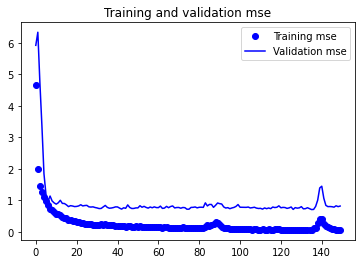

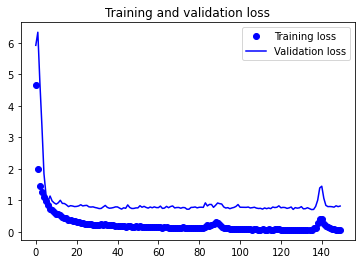

In [25]:
# accuracy = model_train.history['acc']
# val_accuracy = model_train.history['val_acc']
# loss = model_train.history['loss']
# val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training mse')
plt.plot(epochs, val_accuracy, 'b', label='Validation mse')
plt.title('Training and validation mse')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [26]:
predicted_classes = model.predict(test_X)

In [27]:
predicted_value = predicted_classes

In [28]:
a = pd.DataFrame(predicted_value)
b = pd.DataFrame(test_label_array)
c = pd.concat([a,b], axis=1)
c.columns=["Predicted","Test"]

In [29]:
c.to_csv(workdir + '//MEYDC6K_ResNet_pred_obs_table.csv')

In [30]:
c

,Predicted,Test
0,2.103336,2.079442
1,2.095790,2.079442
2,2.076671,2.079442
3,-1.450205,-2.723580
4,2.111608,2.079442
...,...,...
602,2.091429,2.079442
603,2.069661,2.079442
604,2.128259,2.079442
605,0.187499,2.079442


In [31]:
predicted_value.shape

(607, 1)

In [32]:
from scipy.stats import linregress
linregress(b[0], a[0])

LinregressResult(slope=0.9064258667979536, intercept=0.10092491908378887, rvalue=0.8937577007912625, pvalue=8.037103600323976e-213, stderr=0.018494634063842576, intercept_stderr=0.039593055443857716)

In [33]:
from sklearn.metrics import r2_score
r2_value = r2_score(b,a)
print(r2_value)

0.7842146172841995


In [34]:
rse = ((b[0]-a[0])**2).sum()
mse = rse / len(b)
print("Final rmse value is =",np.sqrt(mse))

Final rmse value is = 0.9059363339577867


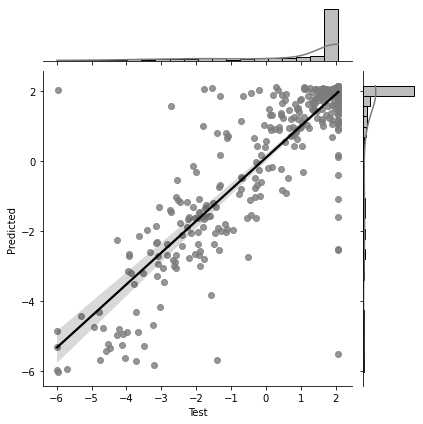

In [35]:
workdir = "D://ResNetIC50//Result//Figure//MEYDC-6K"
import seaborn as sns

g = sns.jointplot(x="Test", y="Predicted", data=c, kind='reg', color='#7C7C7C',
                  joint_kws={'line_kws':{'color':'black'}})
g.savefig(workdir+ '//MEYDC6K_ResNet.png', dpi=300)